In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account
import db_dtypes

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False 



credentials = service_account.Credentials.from_service_account_file(
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"]
)
client = bigquery.Client(
    project="myetl-474505",
    credentials=credentials
)

client.query("SELECT 1").to_dataframe()


/Users/admin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/admin/Library/Python/3.9/lib/python/site-packages/google/api_core/_python_version_support.py:246: FutureWarning: You are using a non-supported Python version (3.9.6). Google will not post any further updates to google.api_core supporting this Python version. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)
/Users/admin/Library/Python/3.9/lib/python/site-packages/google/auth/__init__.py:54: FutureWarning: You are using a Python version 3.9 past its end of life. Google will update google-auth with critical bug fixes on a best-effort basis, but not with any other fixes or features. Please upgrade your Python version, and t

,f0_
0,1


In [3]:
query="""
select min(event_time),max(event_time)
from `myetl-474505.ecommerce.raw_events`
"""

ck=client.query(query).to_dataframe()
ck

/Users/admin/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,f0_,f1_
0,2019-10-01 00:00:00+00:00,2019-10-31 23:59:59+00:00


In [ ]:
#preprocessing
query=""" 
CREATE TABLE `myetl-474505.ecommerce.pre_events`
PARTITION BY event_date AS
SELECT
  event_time,
  date(event_time) as event_date,
  IFNULL(LOWER(category_code), "no_code") AS category_code,
  IFNULL(LOWER(brand), "no_brand") AS brand,
  IFNULL(price, 0) AS price,
  
  LOWER(event_type) AS event_type,
  CAST(product_id AS INT64) AS product_id,
  CAST(category_id AS INT64) AS category_id,
  CAST(user_id AS INT64) AS user_id,
  CAST(user_session AS STRING) AS user_session

FROM `myetl-474505.ecommerce.raw_events`;
"""

job = client.query(query)
job.result() 

In [ ]:
query=""" 
select min(event_date),max(event_date)
from `myetl-474505.ecommerce.pre_events`
"""

ck=client.query(query).to_dataframe()
ck

/Users/admin/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,f0_,f1_
0,2019-10-01,2019-10-31


In [ ]:
query= """ 
select * 
from `myetl-474505.ecommerce.pre_events`
limit 1
"""
sk=client.query(query).to_dataframe()
sk

/Users/admin/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,event_time,event_date,category_code,brand,price,event_type,product_id,category_id,user_id,user_session
0,2019-10-15 18:38:02+00:00,2019-10-15,no_code,a-case,6.67,view,18000726,2053013558525952589,513014131,ac884c90-a017-49ae-9648-126af6f68832


/Users/admin/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


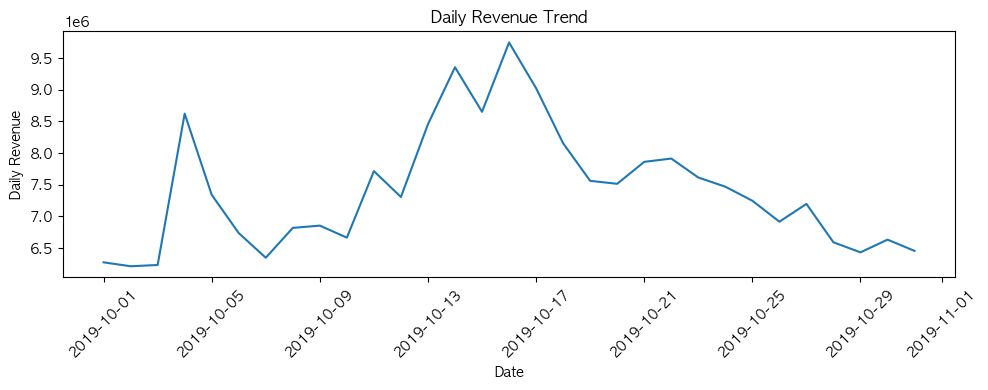

In [63]:
query=""" 
SELECT
  DATE(event_time) AS date,
  COUNT(DISTINCT user_id) AS buyers,
  SUM(price) AS daily_revenue,
  SAFE_DIVIDE(SUM(price), COUNT(DISTINCT user_id)) AS aov
FROM `myetl-474505.ecommerce.pre_events`
WHERE event_type = 'purchase'
GROUP BY date
ORDER BY date;

"""

df=client.query(query).to_dataframe()

plt.figure(figsize=(10,4))
plt.plot(df['date'], df['daily_revenue'])
plt.xlabel('Date')
plt.ylabel('Daily Revenue')
plt.title('Daily Revenue Trend')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

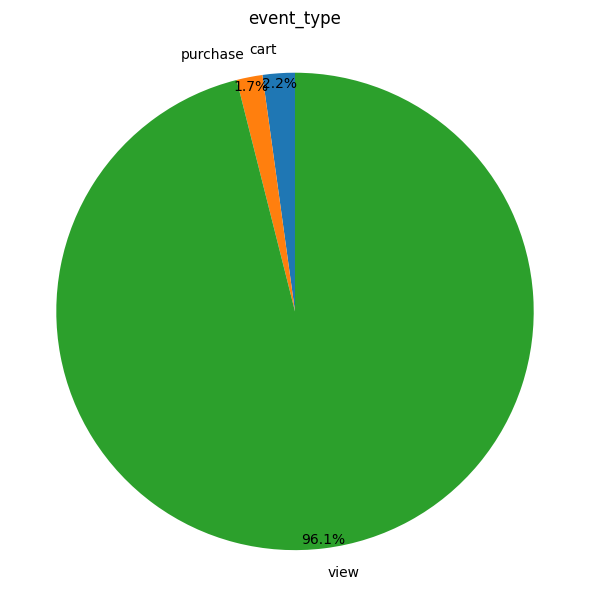

In [ ]:
#이벤트 타입
query=""" 
select event_type, count(*)/sum(count(*)) over()
FROM `myetl-474505.ecommerce.pre_events`
group by event_type;
"""

event_type= client.query(query).to_dataframe()
event_type

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))

plt.pie(
    event_type.iloc[:, 1],
    labels=event_type['event_type'],
    startangle=90,
    autopct='%1.1f%%',
    pctdistance=0.96,   # 퍼센트 위치 (기본 0.6)
    labeldistance=1.1   # 라벨은 더 바깥으로
)

plt.title('event_type', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()




        category       revenue  purchase_cnt
0    electronics  1.764642e+08        423028
1        no_code  2.292494e+07        173425
2     appliances  1.358312e+07         74996
3      computers  1.137887e+07         27855
4      furniture  1.673729e+06          8301
5           auto  1.274032e+06         10620
6   construction  9.329950e+05          7801
7           kids  6.781407e+05          5482
8        apparel  6.249378e+05          8002
9          sport  3.225590e+05          1236
10   accessories  6.878388e+04          1587
11  country_yard  1.569545e+04            72
12      medicine  1.350042e+04           310
13    stationery  2.027380e+03           134


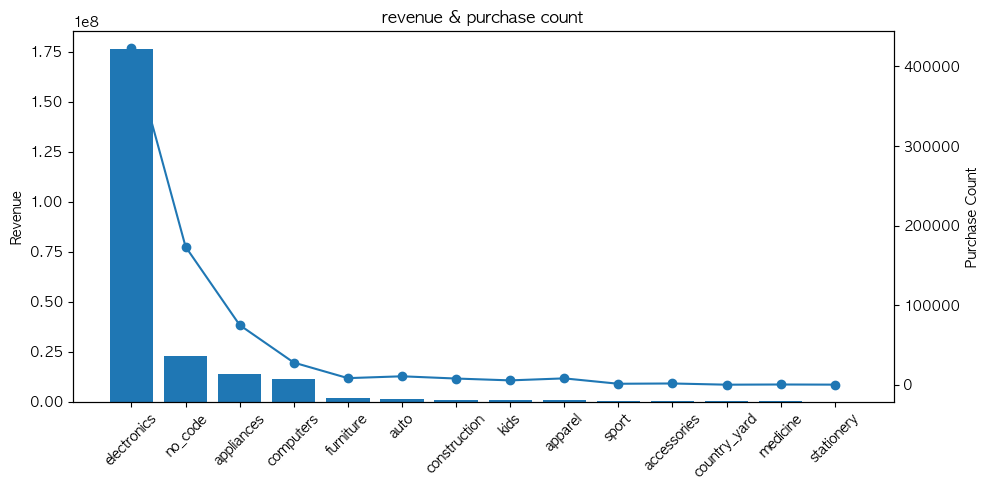

In [ ]:
#매출 높은 카테고리 
query=""" 
SELECT
  SPLIT(category_code, '.')[OFFSET(0)] AS category,
  sum(price) as revenue,
  count(*) as purchase_cnt
FROM `myetl-474505.ecommerce.pre_events`
where event_type='purchase'
group by SPLIT(category_code, '.')[OFFSET(0)]
order by revenue desc;
"""

category=client.query(query).to_dataframe()
category
print(category)

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(category['category'], category['revenue'])
ax1.set_ylabel('Revenue')

ax2 = ax1.twinx()
ax2.plot(category['category'], category['purchase_cnt'], marker='o')
ax2.set_ylabel('Purchase Count')

ax1.set_title('revenue & purchase count')
ax1.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


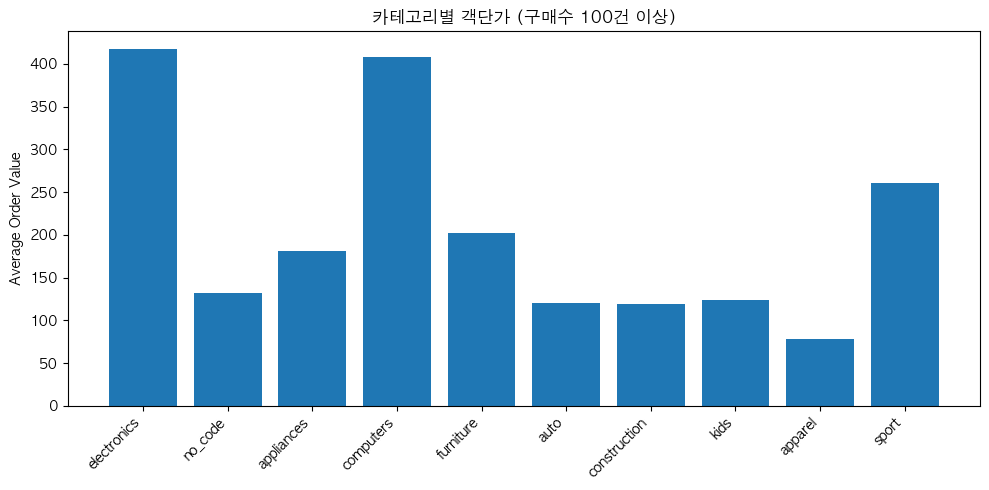

In [ ]:
category['avg_price'] = category['revenue'] / category['purchase_cnt']
df = category[category['purchase_cnt'] >= 100].head(10)

plt.figure(figsize=(10, 5))
plt.bar(df['category'], df['avg_price'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Order Value')
plt.title('카테고리별 객단가 (구매수 100건 이상)')
plt.tight_layout()
plt.show()


/Users/admin/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


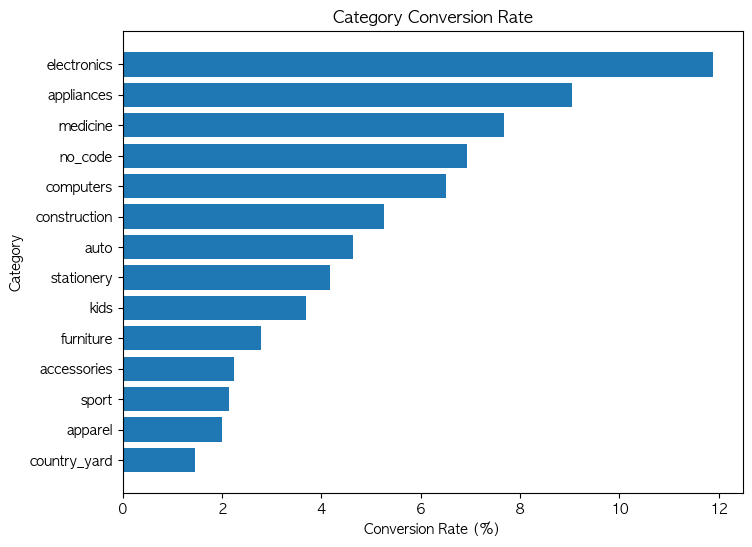

In [ ]:
query="""
select SPLIT(category_code, '.')[OFFSET(0)] AS category,
count(distinct case when event_type='purchase' then user_id end )
/count(distinct user_id)*100.0 as conversion_rate
FROM `myetl-474505.ecommerce.pre_events`
group by SPLIT(category_code, '.')[OFFSET(0)]
order by conversion_rate desc;
"""

conv=client.query(query).to_dataframe()
conv

conv_sorted = conv.sort_values('conversion_rate')

plt.figure(figsize=(8,6))
plt.barh(
    conv_sorted['category'],
    conv_sorted['conversion_rate']
)
plt.xlabel('Conversion Rate (%)')
plt.ylabel('Category')
plt.title('Category Conversion Rate')
plt.show()

In [ ]:
#매출도 높고 객단가가 높은 카테고리인 electroinics
query="""
WITH electronics_events AS (
  SELECT
    user_id,
    event_type
  FROM `myetl-474505.ecommerce.pre_events`
  WHERE SPLIT(category_code, '.')[OFFSET(0)] = 'electronics'
    AND event_type IN ('view', 'cart', 'purchase')
    AND event_date BETWEEN '2019-10-01' AND '2019-10-31'
),base as (
SELECT
  COUNT(DISTINCT IF(event_type = 'view', user_id, NULL)) AS view_users,
  COUNT(DISTINCT IF(event_type = 'cart', user_id, NULL)) AS cart_users,
  COUNT(DISTINCT IF(event_type = 'purchase', user_id, NULL)) AS purchase_users
FROM electronics_events)
SELECT
  SAFE_DIVIDE(cart_users, view_users)      AS cart_view,
  SAFE_DIVIDE(purchase_users, cart_users)  AS purchase_cart,
  SAFE_DIVIDE(purchase_users, view_users)  AS purchase_user_view
FROM base;
"""

cateogry=client.query(query).to_dataframe()
cateogry

/Users/admin/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,cart_view,purchase_cart,purchase_user_view
0,0.144372,0.823092,0.118831


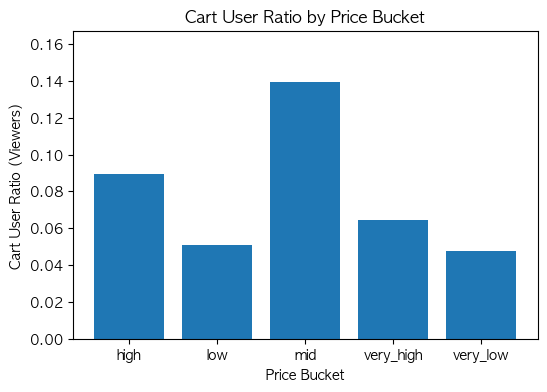

In [18]:
query=""" 
WITH base AS (
  SELECT
    user_id,
    event_type,
    CASE
      when price <=50 then 'very_low'
      WHEN price <= 100 THEN 'low'
      WHEN price <= 300 THEN 'mid'
      WHEN price <= 1000 THEN 'high'
      ELSE 'very_high'
    END AS price_bucket
  FROM `myetl-474505.ecommerce.pre_events`
  WHERE SPLIT(category_code, '.')[OFFSET(0)] = 'electronics')
SELECT
  price_bucket,
  COUNT(DISTINCT IF(event_type = 'view', user_id, NULL)) AS view_users,
  COUNT(DISTINCT IF(event_type = 'cart', user_id, NULL)) AS cart_users,
  SAFE_DIVIDE(
    COUNT(DISTINCT IF(event_type = 'cart', user_id, NULL)),
    COUNT(DISTINCT IF(event_type = 'view', user_id, NULL))
  ) AS view_to_cart_cnv
FROM base
GROUP BY price_bucket
ORDER BY price_bucket;
"""
price=client.query(query).to_dataframe()
price

plt.figure(figsize=(6,4))
plt.bar(price['price_bucket'], price['view_to_cart_cnv'])
plt.xlabel('Price Bucket')
plt.ylabel('Cart User Ratio (Viewers)')
plt.title('Cart User Ratio by Price Bucket')
plt.ylim(0, price['view_to_cart_cnv'].max() * 1.2)
plt.show()

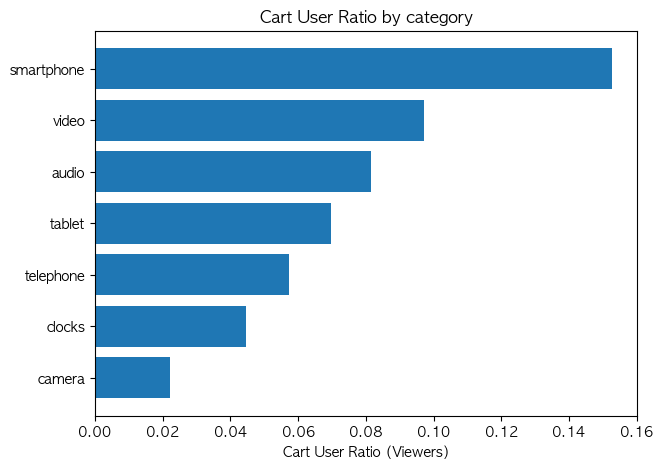

In [19]:
#카테고리중 보고만 가는게 있다(카테고리별 전환율)
query=""" 
WITH base AS (
  SELECT
    user_id,
    event_type,
    SPLIT(category_code, '.')[OFFSET(1)] AS category_l2
  FROM `myetl-474505.ecommerce.pre_events`
  WHERE SPLIT(category_code, '.')[OFFSET(0)] = 'electronics'
)

SELECT
  category_l2,
  COUNT(DISTINCT IF(event_type = 'view', user_id, NULL)) AS view_users,
  COUNT(DISTINCT IF(event_type = 'cart', user_id, NULL)) AS cart_users,
  SAFE_DIVIDE(
    COUNT(DISTINCT IF(event_type = 'cart', user_id, NULL)),
    COUNT(DISTINCT IF(event_type = 'view', user_id, NULL))
  ) AS view_to_cart_cnv
FROM base
GROUP BY category_l2
HAVING view_users > 1000
ORDER BY view_to_cart_cnv DESC;
"""
category=client.query(query).to_dataframe()
category

category_sorted = category.sort_values('view_to_cart_cnv')

plt.figure(figsize=(7,5))
plt.barh(category_sorted['category_l2'], category_sorted['view_to_cart_cnv'])
plt.xlabel('Cart User Ratio (Viewers)')
plt.title('Cart User Ratio by category')
plt.show()

In [15]:
query = """
WITH view_events AS (
  SELECT
    user_id,
    product_id,
    SPLIT(category_code, '.')[OFFSET(1)] AS category_l2,
    MIN(event_time) AS first_view_time
  FROM `myetl-474505.ecommerce.pre_events`
  WHERE event_type = 'view'
    AND SPLIT(category_code, '.')[OFFSET(0)] = 'electronics'
  GROUP BY user_id, product_id, category_l2
),
cart_events AS (
  SELECT
    user_id,
    product_id,
    MIN(event_time) AS first_cart_time
  FROM `myetl-474505.ecommerce.pre_events`
  WHERE event_type = 'cart'
  GROUP BY user_id, product_id
)

SELECT
  v.category_l2,
  TIMESTAMP_DIFF(
    c.first_cart_time,
    v.first_view_time,
    MINUTE
  ) AS minutes_to_cart
FROM view_events v
JOIN cart_events c
  ON v.user_id = c.user_id
 AND v.product_id = c.product_id
WHERE c.first_cart_time > v.first_view_time
  AND v.category_l2 IN ('smartphone', 'camera');
"""
df = client.query(query).to_dataframe()

df_quantile = (
    df.groupby('category_l2')['minutes_to_cart']
      .quantile([0.25, 0.5, 0.75])
      .unstack()
)

df_quantile


/Users/admin/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,0.25,0.50,0.75
category_l2,,,
camera,0.0,2.0,1121.0
smartphone,0.0,1.0,12.0
